# Drug Data Analysis for Machine Learning - Part 2
## Focus: Side Effect Classification & Advanced Analytics

This notebook provides advanced analysis for:
- Side Effect Classification Models
- Text Mining of Side Effects
- Risk Assessment Patterns
- Advanced Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

# Load the data
df = pd.read_csv('realistic_drug_labels_side_effects.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Focus: Side Effect Analysis & Advanced ML Features")

Dataset loaded successfully!
Shape: (1436, 15)
Focus: Side Effect Analysis & Advanced ML Features


## 1. Side Effect Text Mining and Analysis

Total unique side effects: 10
Most common side effects:
  Blurred vision: 302 (21.0% of drugs)
  Dry mouth: 297 (20.7% of drugs)
  Headache: 294 (20.5% of drugs)
  Rash: 293 (20.4% of drugs)
  Diarrhea: 285 (19.8% of drugs)
  Fatigue: 282 (19.6% of drugs)
  Dizziness: 281 (19.6% of drugs)
  Insomnia: 272 (18.9% of drugs)
  Nausea: 269 (18.7% of drugs)
  Constipation: 262 (18.2% of drugs)


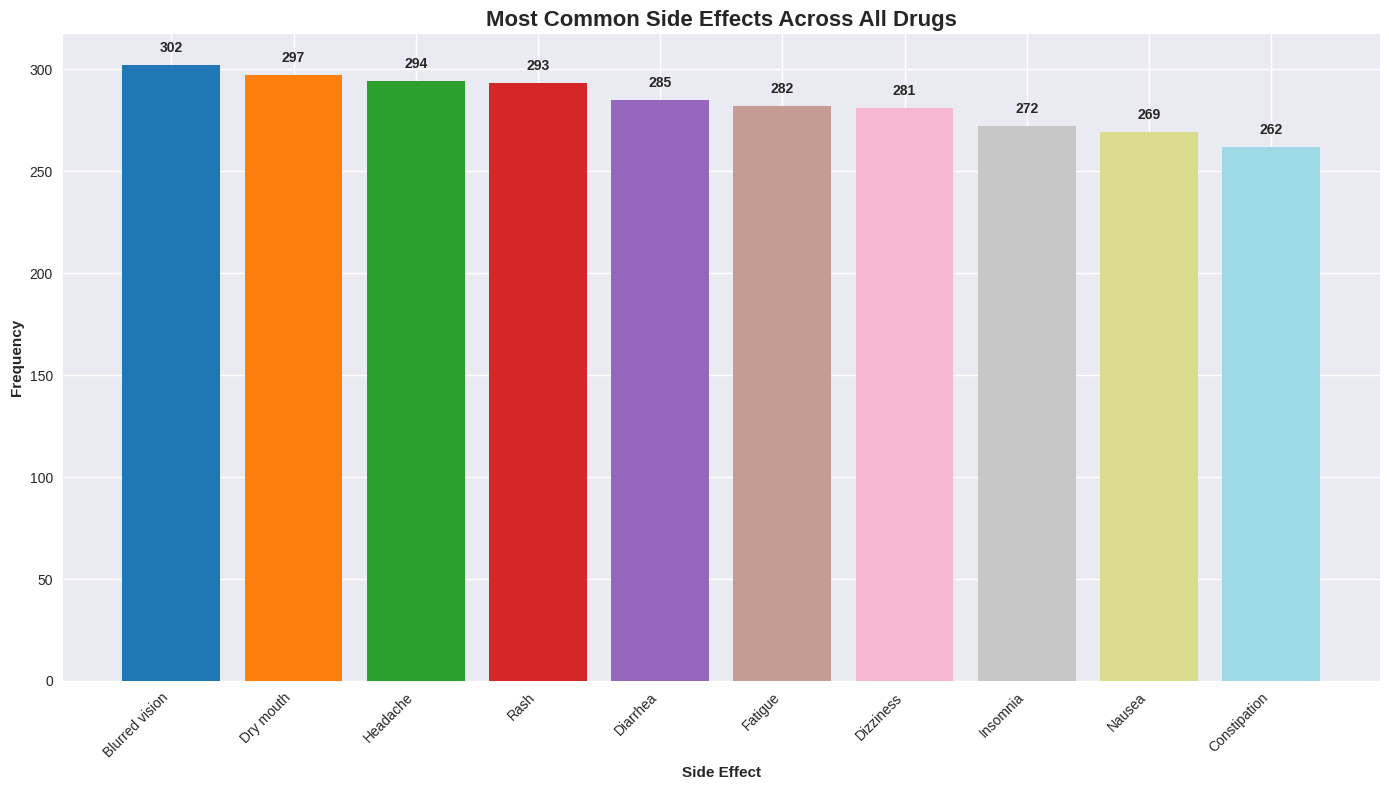

In [2]:
# Parse and analyze side effects
def parse_side_effects(side_effects_str):
    """Parse side effects string into list"""
    if pd.isna(side_effects_str) or side_effects_str == '':
        return []
    # Clean and split side effects
    effects = [effect.strip() for effect in str(side_effects_str).split(',')]
    return [effect for effect in effects if effect]

# Extract all side effects
all_side_effects = []
side_effect_counts = Counter()
df['side_effects_list'] = df['side_effects'].apply(parse_side_effects)
df['num_side_effects'] = df['side_effects_list'].apply(len)

for effects_list in df['side_effects_list']:
    all_side_effects.extend(effects_list)
    side_effect_counts.update(effects_list)

print(f"Total unique side effects: {len(side_effect_counts)}")
print(f"Most common side effects:")
for effect, count in side_effect_counts.most_common(15):
    print(f"  {effect}: {count} ({count/len(df)*100:.1f}% of drugs)")

# Visualize top side effects
top_effects = dict(side_effect_counts.most_common(12))
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(range(len(top_effects)), list(top_effects.values()), 
              color=plt.cm.tab20(np.linspace(0, 1, len(top_effects))))
ax.set_title('Most Common Side Effects Across All Drugs', fontsize=16, fontweight='bold')
ax.set_xlabel('Side Effect', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_xticks(range(len(top_effects)))
ax.set_xticklabels(list(top_effects.keys()), rotation=45, ha='right')

# Add value labels
for i, v in enumerate(top_effects.values()):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


SIDE EFFECT PROFILES BY DRUG CLASS:

Antidepressant:
  Insomnia: 41
  Blurred vision: 34
  Headache: 33
  Fatigue: 30
  Dry mouth: 30

Vaccine:
  Dry mouth: 37
  Dizziness: 33
  Headache: 32
  Fatigue: 31
  Insomnia: 30

Antipsychotic:
  Rash: 42
  Diarrhea: 40
  Blurred vision: 32
  Fatigue: 31
  Headache: 29

Antifungal:
  Insomnia: 40
  Blurred vision: 35
  Dry mouth: 34
  Dizziness: 33
  Rash: 32


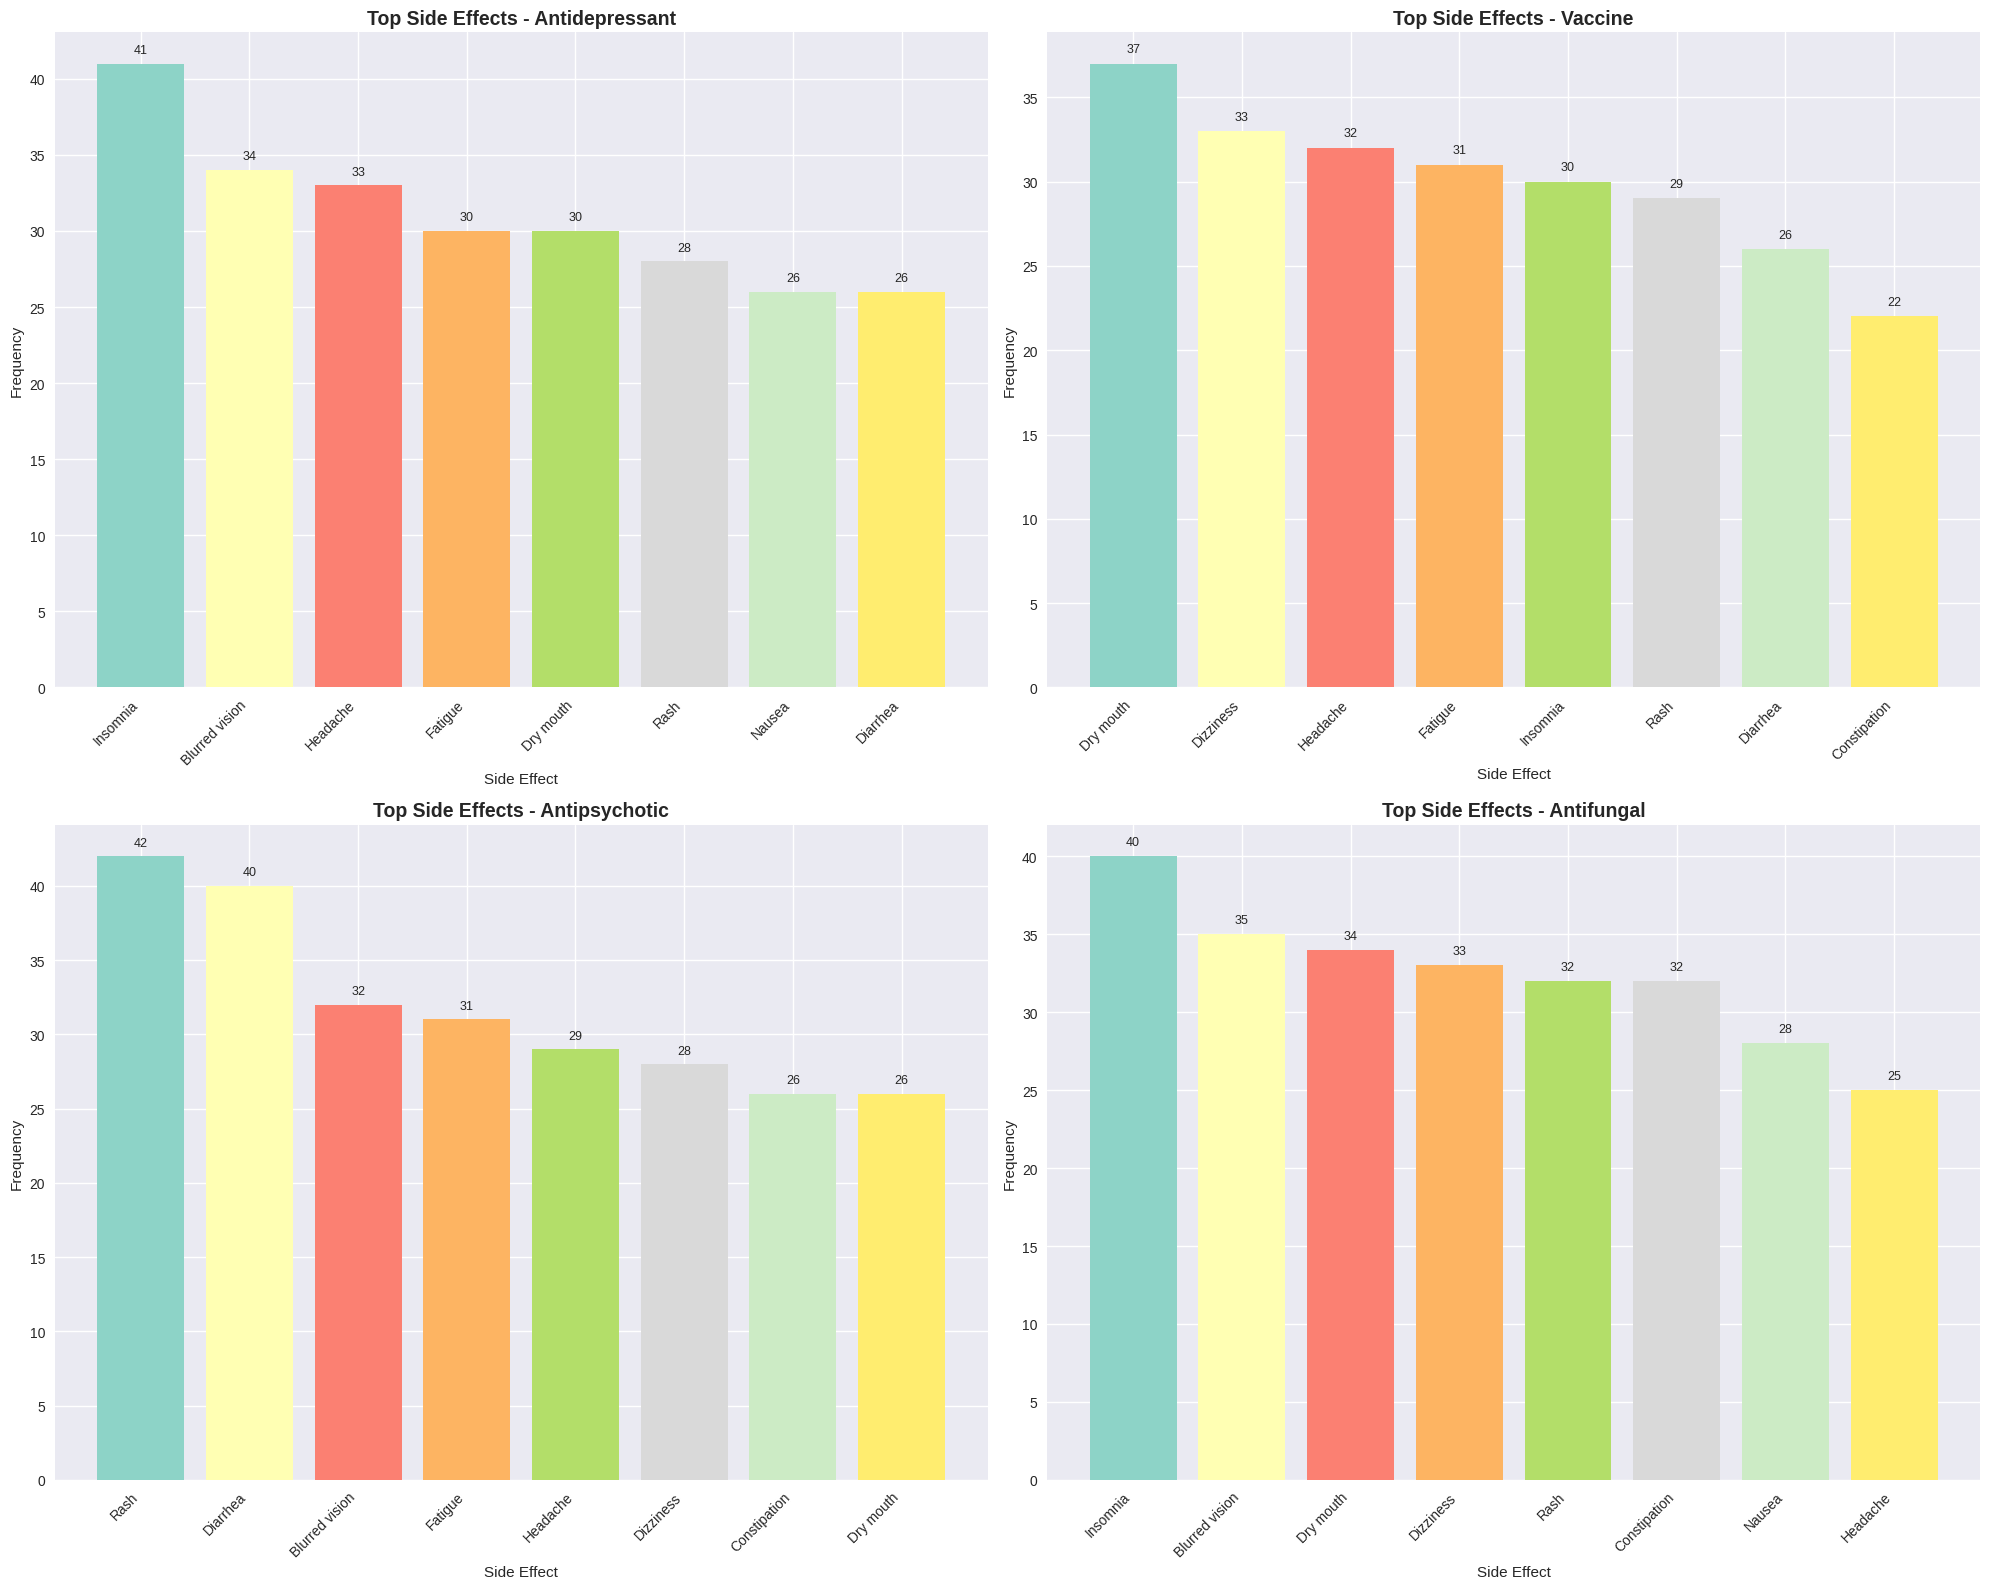

In [3]:
# Side effect patterns by drug class
class_side_effects = defaultdict(Counter)

for idx, row in df.iterrows():
    drug_class = row['drug_class']
    effects = row['side_effects_list']
    class_side_effects[drug_class].update(effects)

# Create side effect profile for each drug class
print("\nSIDE EFFECT PROFILES BY DRUG CLASS:")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

drug_classes = list(class_side_effects.keys())[:4]  # Top 4 classes

for i, drug_class in enumerate(drug_classes):
    top_effects_class = dict(class_side_effects[drug_class].most_common(8))
    
    bars = axes[i].bar(range(len(top_effects_class)), list(top_effects_class.values()),
                       color=plt.cm.Set3(np.linspace(0, 1, len(top_effects_class))))
    axes[i].set_title(f'Top Side Effects - {drug_class}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Side Effect')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(range(len(top_effects_class)))
    axes[i].set_xticklabels(list(top_effects_class.keys()), rotation=45, ha='right')
    
    # Add value labels
    for j, v in enumerate(top_effects_class.values()):
        axes[i].text(j, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)
    
    print(f"\n{drug_class}:")
    for effect, count in class_side_effects[drug_class].most_common(5):
        print(f"  {effect}: {count}")

plt.tight_layout()
plt.show()

## 2. Side Effect Severity Classification Analysis

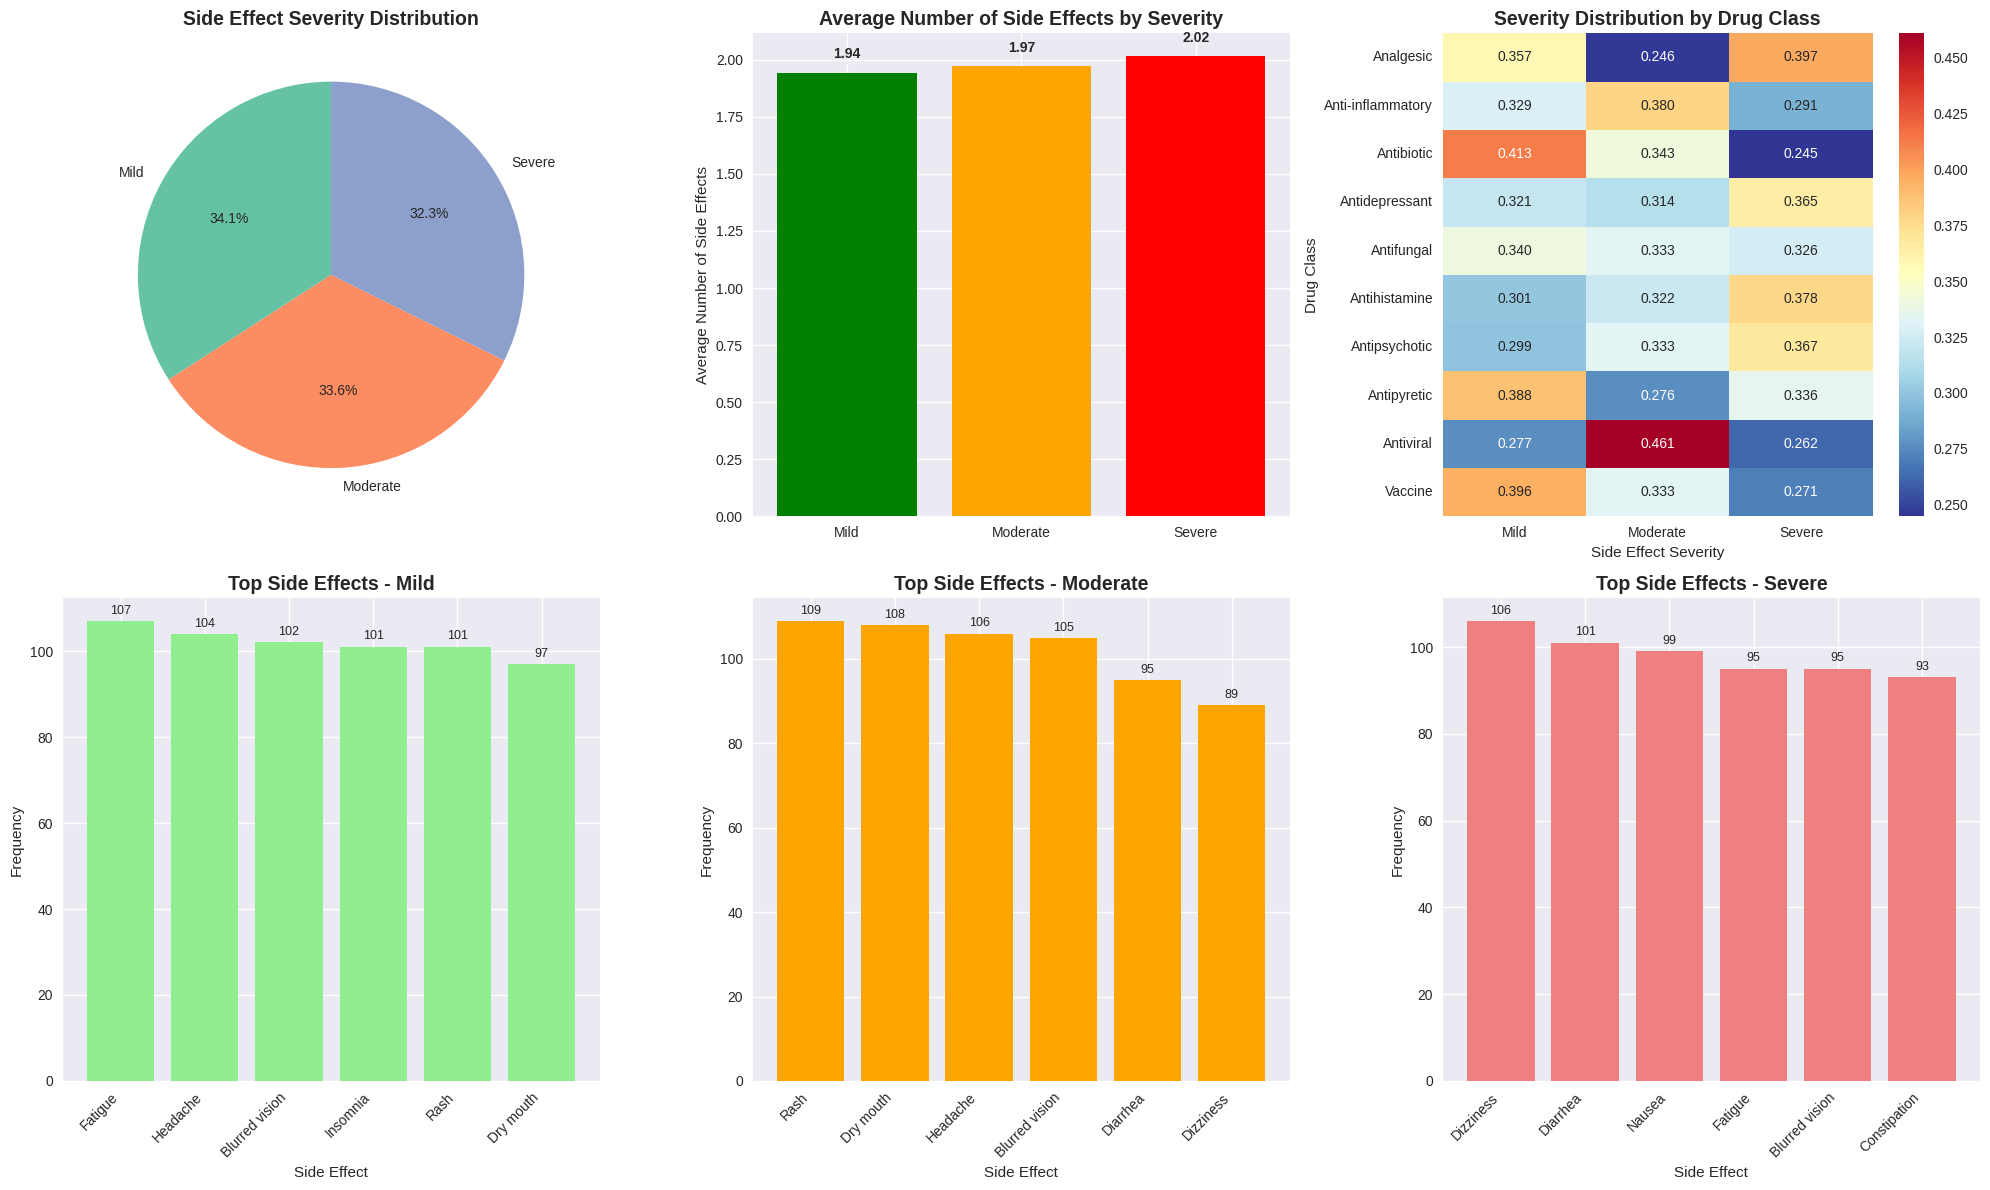


SIDE EFFECT SEVERITY INSIGHTS:
Average side effects per drug: 1.98
Max side effects for single drug: 3

Severity-specific patterns:
  Mild: 1.94 average side effects
  Moderate: 1.97 average side effects
  Severe: 2.02 average side effects


In [4]:
# Analyze relationship between side effects and severity
severity_side_effects = defaultdict(Counter)

for idx, row in df.iterrows():
    severity = row['side_effect_severity']
    effects = row['side_effects_list']
    severity_side_effects[severity].update(effects)

# Create comprehensive severity analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Severity distribution
severity_counts = df['side_effect_severity'].value_counts()
axes[0,0].pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Side Effect Severity Distribution', fontsize=14, fontweight='bold')

# Number of side effects by severity
severity_num_effects = df.groupby('side_effect_severity')['num_side_effects'].mean()
bars = axes[0,1].bar(severity_num_effects.index, severity_num_effects.values, 
                     color=['green', 'orange', 'red'])
axes[0,1].set_title('Average Number of Side Effects by Severity', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Average Number of Side Effects')

# Add value labels
for i, v in enumerate(severity_num_effects.values):
    axes[0,1].text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Severity by drug class heatmap
severity_class_crosstab = pd.crosstab(df['drug_class'], df['side_effect_severity'], normalize='index')
sns.heatmap(severity_class_crosstab, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=axes[0,2])
axes[0,2].set_title('Severity Distribution by Drug Class', fontsize=14, fontweight='bold')
axes[0,2].set_xlabel('Side Effect Severity')
axes[0,2].set_ylabel('Drug Class')

# Top side effects by severity
severities = ['Mild', 'Moderate', 'Severe']
colors = ['lightgreen', 'orange', 'lightcoral']

for i, (severity, color) in enumerate(zip(severities, colors)):
    if severity in severity_side_effects:
        top_effects = dict(severity_side_effects[severity].most_common(6))
        bars = axes[1,i].bar(range(len(top_effects)), list(top_effects.values()), color=color)
        axes[1,i].set_title(f'Top Side Effects - {severity}', fontsize=14, fontweight='bold')
        axes[1,i].set_xlabel('Side Effect')
        axes[1,i].set_ylabel('Frequency')
        axes[1,i].set_xticks(range(len(top_effects)))
        axes[1,i].set_xticklabels(list(top_effects.keys()), rotation=45, ha='right')
        
        # Add value labels
        for j, v in enumerate(top_effects.values()):
            axes[1,i].text(j, v + 1, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nSIDE EFFECT SEVERITY INSIGHTS:")
print(f"Average side effects per drug: {df['num_side_effects'].mean():.2f}")
print(f"Max side effects for single drug: {df['num_side_effects'].max()}")
print("\nSeverity-specific patterns:")
for severity in severities:
    if severity in severity_side_effects:
        avg_effects = df[df['side_effect_severity'] == severity]['num_side_effects'].mean()
        print(f"  {severity}: {avg_effects:.2f} average side effects")

## 3. Risk Assessment and Contraindications Analysis

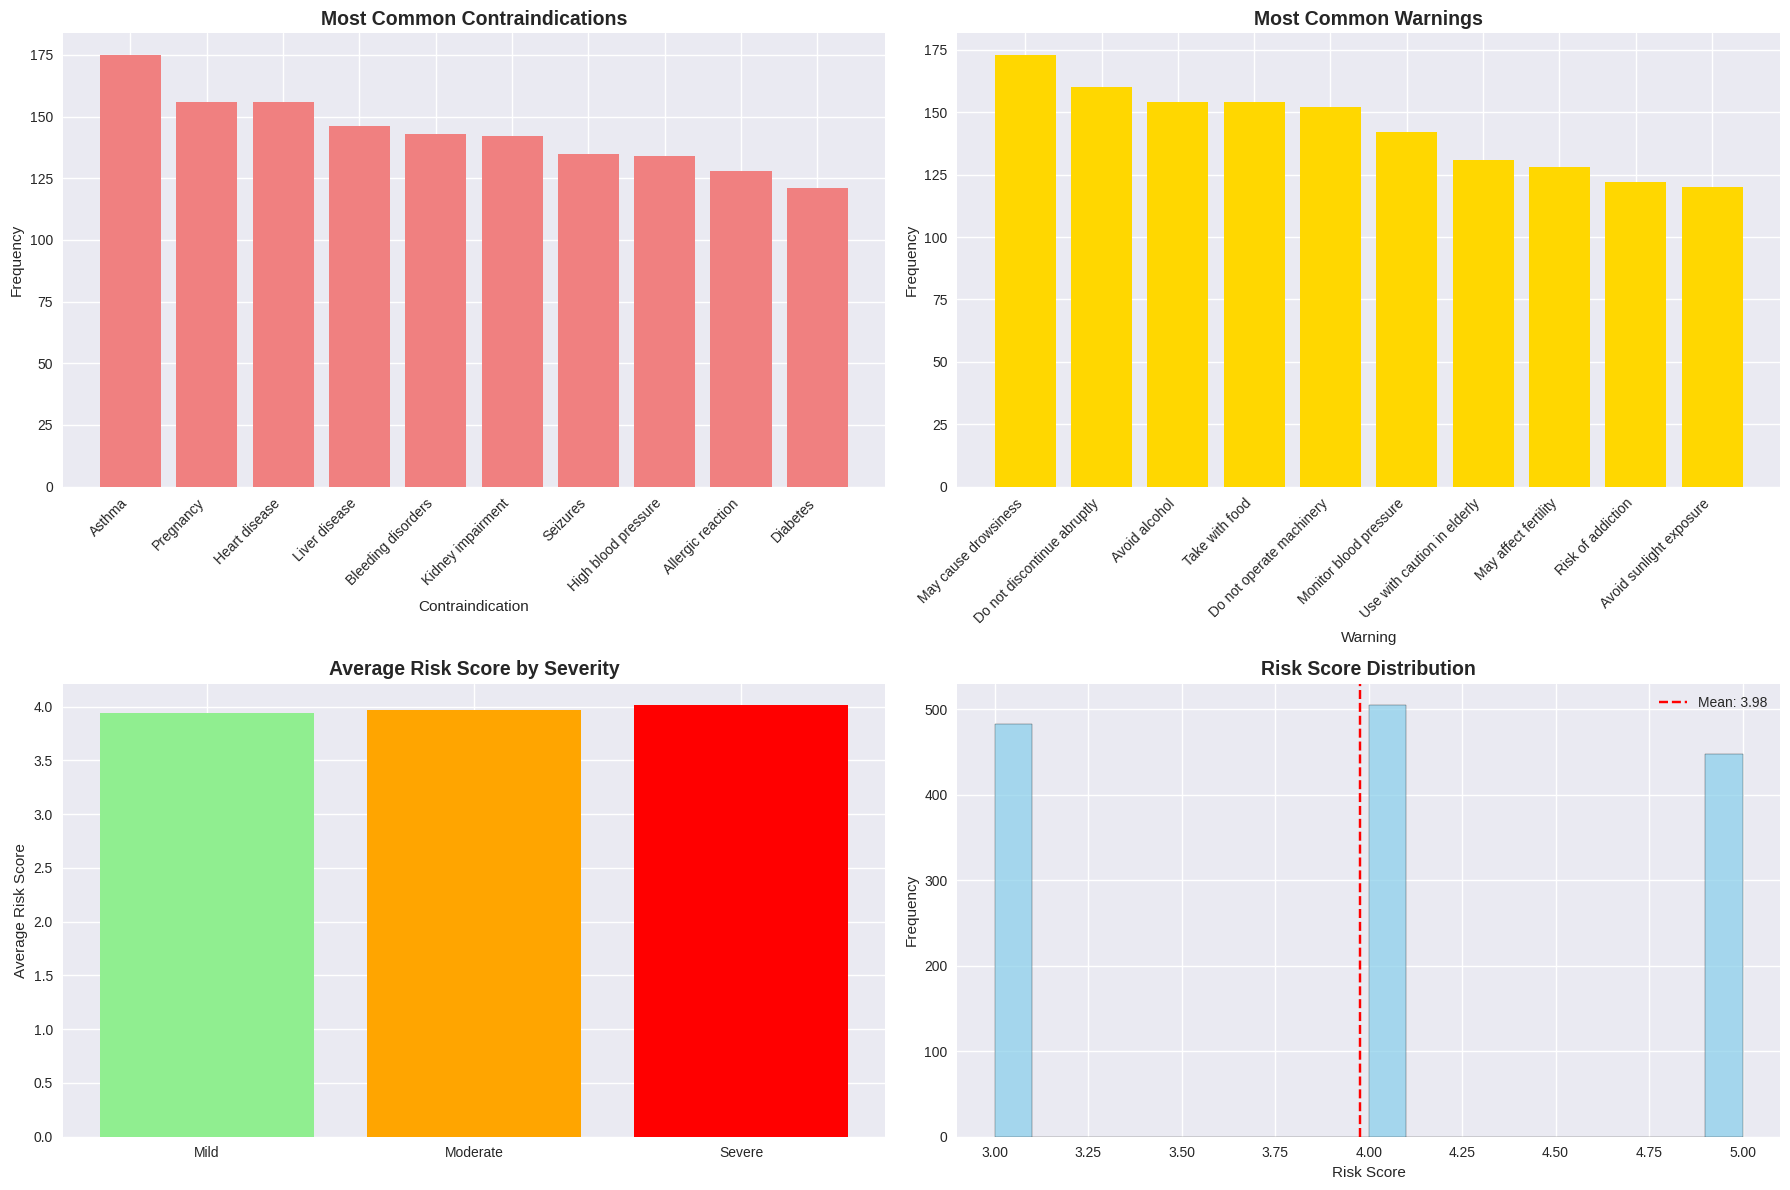


RISK ASSESSMENT INSIGHTS:
Average risk score: 3.98
Highest risk score: 5

Top Contraindications:
  Asthma: 175
  Pregnancy: 156
  Heart disease: 156
  Liver disease: 146
  Bleeding disorders: 143

Top Warnings:
  May cause drowsiness: 173
  Do not discontinue abruptly: 160
  Avoid alcohol: 154
  Take with food: 154
  Do not operate machinery: 152


In [5]:
# Analyze contraindications and warnings
def parse_text_field(text_field):
    """Parse text fields like contraindications and warnings"""
    if pd.isna(text_field) or text_field == '':
        return []
    # Simple parsing - could be enhanced with NLP
    return [item.strip() for item in str(text_field).split(',') if item.strip()]

# Parse contraindications and warnings
df['contraindications_list'] = df['contraindications'].apply(parse_text_field)
df['warnings_list'] = df['warnings'].apply(parse_text_field)

# Count contraindications and warnings
all_contraindications = []
all_warnings = []

for contras in df['contraindications_list']:
    all_contraindications.extend(contras)
    
for warnings in df['warnings_list']:
    all_warnings.extend(warnings)

contra_counts = Counter(all_contraindications)
warning_counts = Counter(all_warnings)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top contraindications
top_contras = dict(contra_counts.most_common(10))
bars = axes[0,0].bar(range(len(top_contras)), list(top_contras.values()), color='lightcoral')
axes[0,0].set_title('Most Common Contraindications', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Contraindication')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_xticks(range(len(top_contras)))
axes[0,0].set_xticklabels(list(top_contras.keys()), rotation=45, ha='right')

# Top warnings
top_warnings = dict(warning_counts.most_common(10))
bars = axes[0,1].bar(range(len(top_warnings)), list(top_warnings.values()), color='gold')
axes[0,1].set_title('Most Common Warnings', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Warning')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_xticks(range(len(top_warnings)))
axes[0,1].set_xticklabels(list(top_warnings.keys()), rotation=45, ha='right')

# Risk score analysis
df['risk_score'] = (df['side_effects_list'].apply(len) + 
                   df['contraindications_list'].apply(len) + 
                   df['warnings_list'].apply(len))

# Risk score by severity
risk_by_severity = df.groupby('side_effect_severity')['risk_score'].mean()
bars = axes[1,0].bar(risk_by_severity.index, risk_by_severity.values, 
                     color=['lightgreen', 'orange', 'red'])
axes[1,0].set_title('Average Risk Score by Severity', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Average Risk Score')

# Risk score distribution
axes[1,1].hist(df['risk_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,1].set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Risk Score')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(df['risk_score'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {df["risk_score"].mean():.2f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("\nRISK ASSESSMENT INSIGHTS:")
print(f"Average risk score: {df['risk_score'].mean():.2f}")
print(f"Highest risk score: {df['risk_score'].max()}")
print(f"\nTop Contraindications:")
for contra, count in contra_counts.most_common(5):
    print(f"  {contra}: {count}")
print(f"\nTop Warnings:")
for warning, count in warning_counts.most_common(5):
    print(f"  {warning}: {count}")

## 4. Advanced Feature Engineering for ML Models

=== ADVANCED FEATURE ENGINEERING ===
Created 10 binary side effect features

New Features Created:
  risk_category: 2 unique values
  dosage_category: 3 unique values
  price_category: 3 unique values
  years_since_approval: 35 unique values
  approval_decade: 4 unique values
  mfg_class_combo: 100 unique values


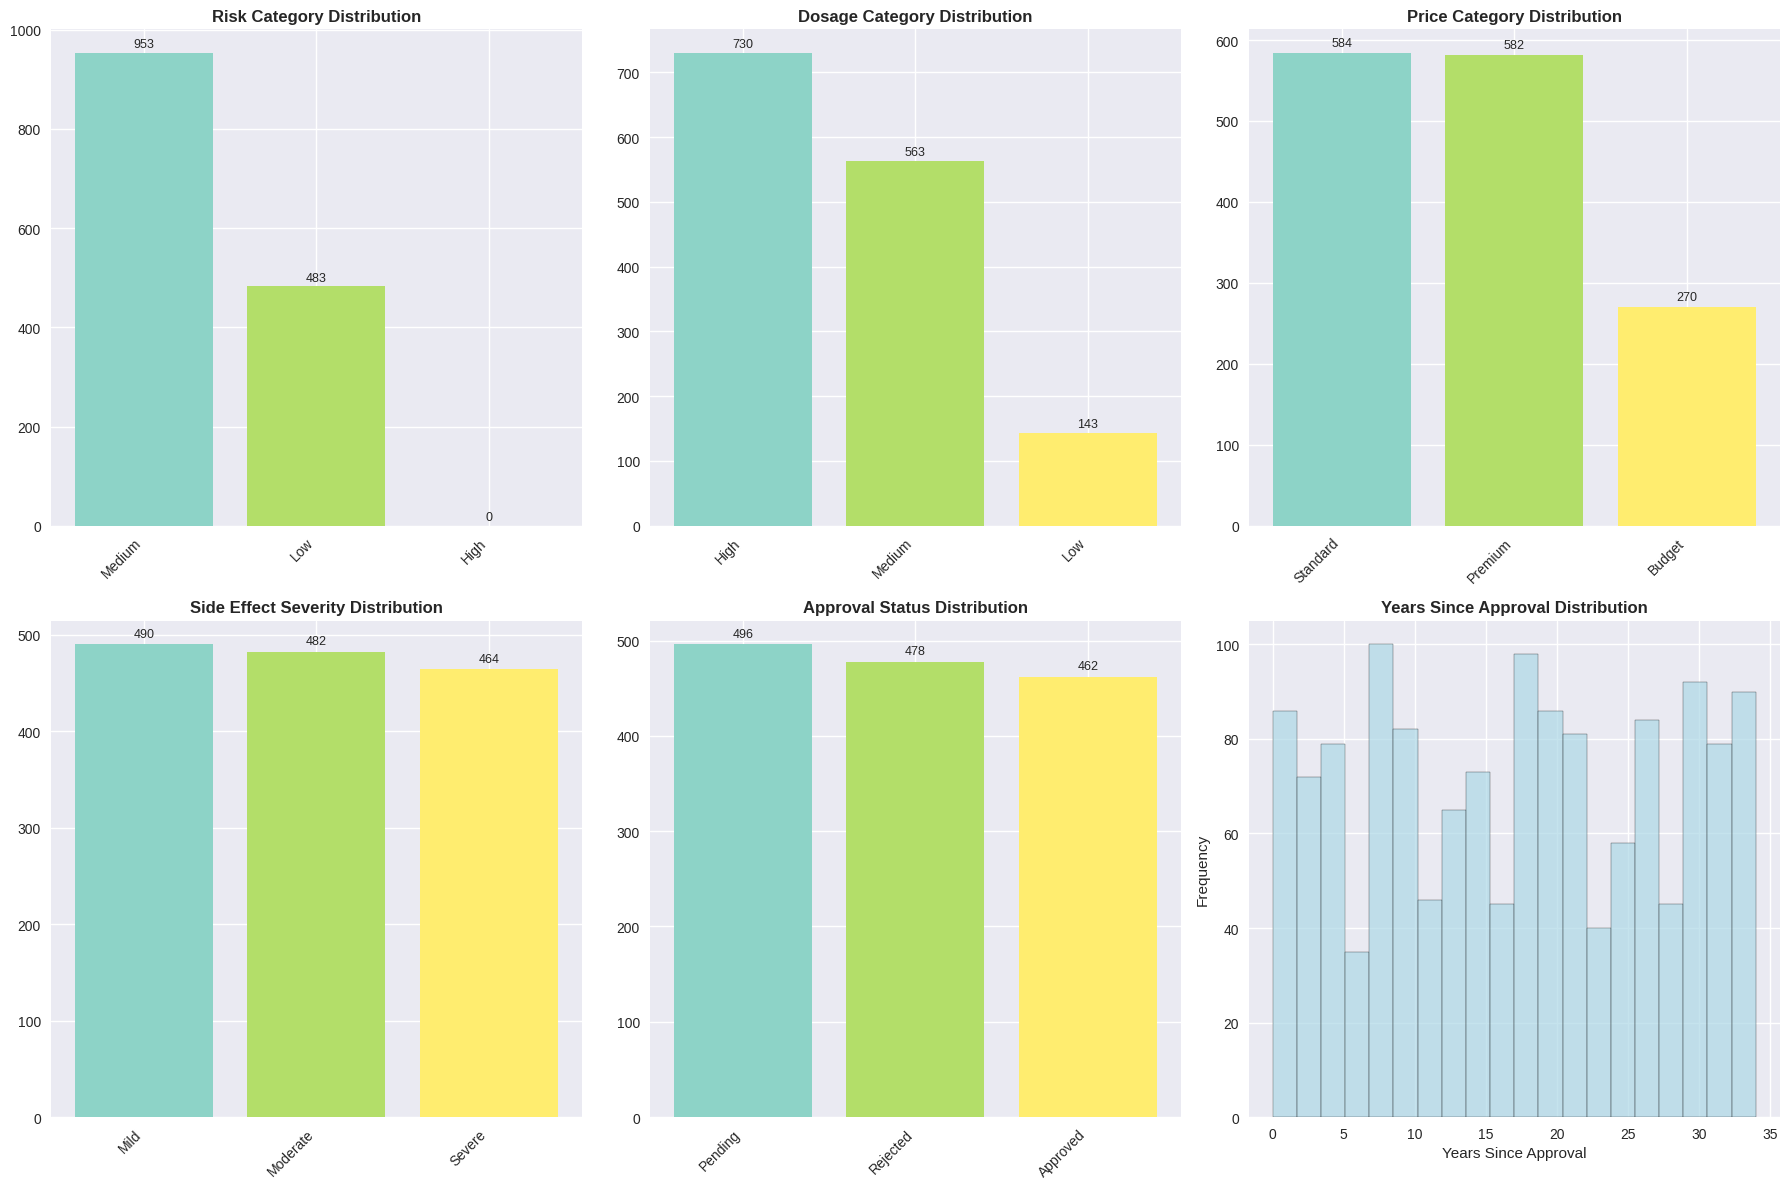

In [6]:
# Create advanced features for ML models
print("=== ADVANCED FEATURE ENGINEERING ===")

# 1. Side Effect Features
# Create binary features for common side effects
common_side_effects = [effect for effect, count in side_effect_counts.most_common(10)]

for effect in common_side_effects:
    df[f'has_{effect.lower().replace(" ", "_")}'] = df['side_effects_list'].apply(
        lambda x: 1 if effect in x else 0
    )

print(f"Created {len(common_side_effects)} binary side effect features")

# 2. Risk Category Features
df['risk_category'] = pd.cut(df['risk_score'], 
                            bins=[0, 3, 6, float('inf')], 
                            labels=['Low', 'Medium', 'High'])

# 3. Dosage Categories
df['dosage_category'] = pd.cut(df['dosage_mg'], 
                              bins=[0, 100, 500, float('inf')], 
                              labels=['Low', 'Medium', 'High'])

# 4. Price Categories
df['price_category'] = pd.cut(df['price_usd'], 
                             bins=[0, 100, 300, float('inf')], 
                             labels=['Budget', 'Standard', 'Premium'])

# 5. Temporal Features
df['years_since_approval'] = 2024 - df['approval_year']
df['approval_decade'] = (df['approval_year'] // 10) * 10

# 6. Interaction Features
# Manufacturer-Class combinations
df['mfg_class_combo'] = df['manufacturer'] + '_' + df['drug_class']

# Display feature engineering results
print("\nNew Features Created:")
new_features = ['risk_category', 'dosage_category', 'price_category', 
               'years_since_approval', 'approval_decade', 'mfg_class_combo']
for feature in new_features:
    print(f"  {feature}: {df[feature].nunique()} unique values")

# Visualize new categorical features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

categorical_features = ['risk_category', 'dosage_category', 'price_category', 
                       'side_effect_severity', 'approval_status']

for i, feature in enumerate(categorical_features):
    if i < len(axes):
        feature_counts = df[feature].value_counts()
        bars = axes[i].bar(range(len(feature_counts)), feature_counts.values,
                          color=plt.cm.Set3(np.linspace(0, 1, len(feature_counts))))
        axes[i].set_title(f'{feature.replace("_", " ").title()} Distribution', 
                         fontsize=12, fontweight='bold')
        axes[i].set_xticks(range(len(feature_counts)))
        axes[i].set_xticklabels(feature_counts.index, rotation=45, ha='right')
        
        # Add value labels
        for j, v in enumerate(feature_counts.values):
            axes[i].text(j, v + 5, str(v), ha='center', va='bottom', fontsize=9)

# Years since approval distribution
axes[5].hist(df['years_since_approval'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[5].set_title('Years Since Approval Distribution', fontsize=12, fontweight='bold')
axes[5].set_xlabel('Years Since Approval')
axes[5].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Text Feature Engineering for Side Effects

=== TEXT FEATURE ENGINEERING ===
Created 12 TF-IDF features from side effects
TF-IDF Features: ['blurred', 'constipation', 'diarrhea', 'dizziness', 'dry', 'fatigue', 'headache', 'insomnia', 'mouth', 'nausea', 'rash', 'vision']


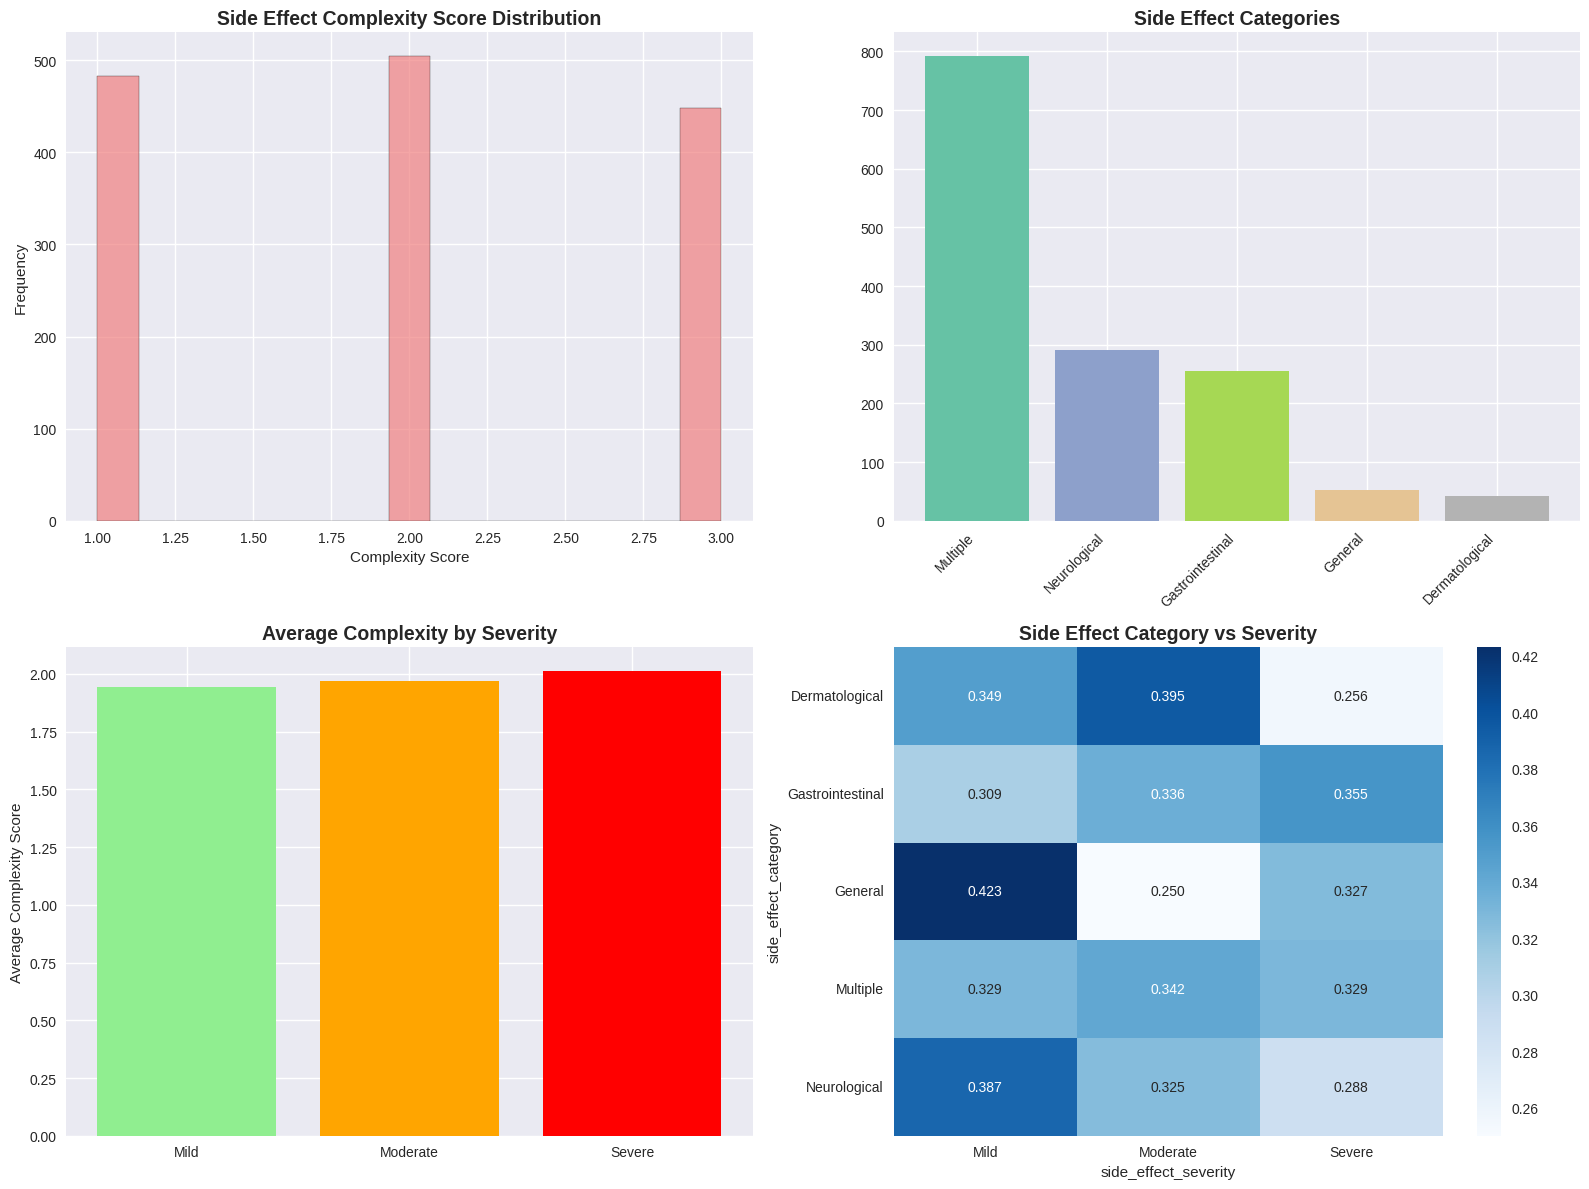


TEXT FEATURE INSIGHTS:
Average complexity score: 1.98
Max complexity score: 3

Side Effect Categories:
  Multiple: 793 (55.2%)
  Neurological: 292 (20.3%)
  Gastrointestinal: 256 (17.8%)
  General: 52 (3.6%)
  Dermatological: 43 (3.0%)


In [7]:
# Advanced text feature engineering
print("=== TEXT FEATURE ENGINEERING ===")

# 1. TF-IDF Features for side effects
# Prepare side effects text
side_effects_text = df['side_effects'].fillna('').astype(str)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=20, stop_words=None, lowercase=True)
tfidf_matrix = tfidf.fit_transform(side_effects_text)
tfidf_features = tfidf.get_feature_names_out()

print(f"Created {len(tfidf_features)} TF-IDF features from side effects")
print(f"TF-IDF Features: {list(tfidf_features)}")

# 2. Side Effect Complexity Score
def calculate_complexity_score(effects_list):
    """Calculate complexity based on number and type of side effects"""
    if not effects_list:
        return 0
    
    # Weight different types of side effects
    serious_effects = ['seizures', 'heart', 'liver', 'kidney', 'bleeding']
    complexity = len(effects_list)  # Base complexity
    
    # Add weight for serious effects
    for effect in effects_list:
        effect_lower = effect.lower()
        for serious in serious_effects:
            if serious in effect_lower:
                complexity += 2
                break
    
    return complexity

df['side_effect_complexity'] = df['side_effects_list'].apply(calculate_complexity_score)

# 3. Create side effect categories
def categorize_side_effects(effects_list):
    """Categorize side effects into body systems"""
    if not effects_list:
        return 'None'
    
    categories = {
        'Neurological': ['headache', 'dizziness', 'insomnia', 'blurred vision'],
        'Gastrointestinal': ['nausea', 'diarrhea', 'constipation', 'dry mouth'],
        'Dermatological': ['rash'],
        'General': ['fatigue']
    }
    
    found_categories = set()
    for effect in effects_list:
        effect_lower = effect.lower()
        for category, keywords in categories.items():
            if any(keyword in effect_lower for keyword in keywords):
                found_categories.add(category)
    
    if not found_categories:
        return 'Other'
    elif len(found_categories) == 1:
        return list(found_categories)[0]
    else:
        return 'Multiple'

df['side_effect_category'] = df['side_effects_list'].apply(categorize_side_effects)

# Visualize text features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Side effect complexity distribution
axes[0,0].hist(df['side_effect_complexity'], bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,0].set_title('Side Effect Complexity Score Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Complexity Score')
axes[0,0].set_ylabel('Frequency')

# Side effect categories
category_counts = df['side_effect_category'].value_counts()
bars = axes[0,1].bar(range(len(category_counts)), category_counts.values,
                     color=plt.cm.Set2(np.linspace(0, 1, len(category_counts))))
axes[0,1].set_title('Side Effect Categories', fontsize=14, fontweight='bold')
axes[0,1].set_xticks(range(len(category_counts)))
axes[0,1].set_xticklabels(category_counts.index, rotation=45, ha='right')

# Complexity by severity
complexity_by_severity = df.groupby('side_effect_severity')['side_effect_complexity'].mean()
bars = axes[1,0].bar(complexity_by_severity.index, complexity_by_severity.values,
                     color=['lightgreen', 'orange', 'red'])
axes[1,0].set_title('Average Complexity by Severity', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Average Complexity Score')

# Category by severity heatmap
category_severity_crosstab = pd.crosstab(df['side_effect_category'], df['side_effect_severity'], normalize='index')
sns.heatmap(category_severity_crosstab, annot=True, fmt='.3f', cmap='Blues', ax=axes[1,1])
axes[1,1].set_title('Side Effect Category vs Severity', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTEXT FEATURE INSIGHTS:")
print(f"Average complexity score: {df['side_effect_complexity'].mean():.2f}")
print(f"Max complexity score: {df['side_effect_complexity'].max()}")
print(f"\nSide Effect Categories:")
for category, count in category_counts.items():
    print(f"  {category}: {count} ({count/len(df)*100:.1f}%)")

## 6. ML Model Recommendations and Feature Selection

=== MACHINE LEARNING MODEL RECOMMENDATIONS ===

1. FEATURE INVENTORY:
   Categorical Features: 10 features
   Numerical Features: 7 features
   Binary Features: 10 features
   Text Features: 12 features
   Total Features Available: 39

2. MODEL-SPECIFIC RECOMMENDATIONS:

   A. SIDE EFFECT SEVERITY CLASSIFICATION:
      Target: side_effect_severity (Mild/Moderate/Severe)
      Key Features:
      - drug_class, dosage_mg, administration_route
      - Binary side effect features
      - side_effect_complexity, num_side_effects
      - manufacturer (quality patterns)
      Recommended Algorithms:
      - Random Forest (handles mixed data types)
      - XGBoost (excellent for tabular data)
      - SVM with RBF kernel (for complex boundaries)

   B. SIDE EFFECT CATEGORY PREDICTION:
      Target: side_effect_category
      Key Features:
      - drug_class, dosage_mg, administration_route
      - TF-IDF features from side effects text
      - contraindications and warnings text
      Recommend

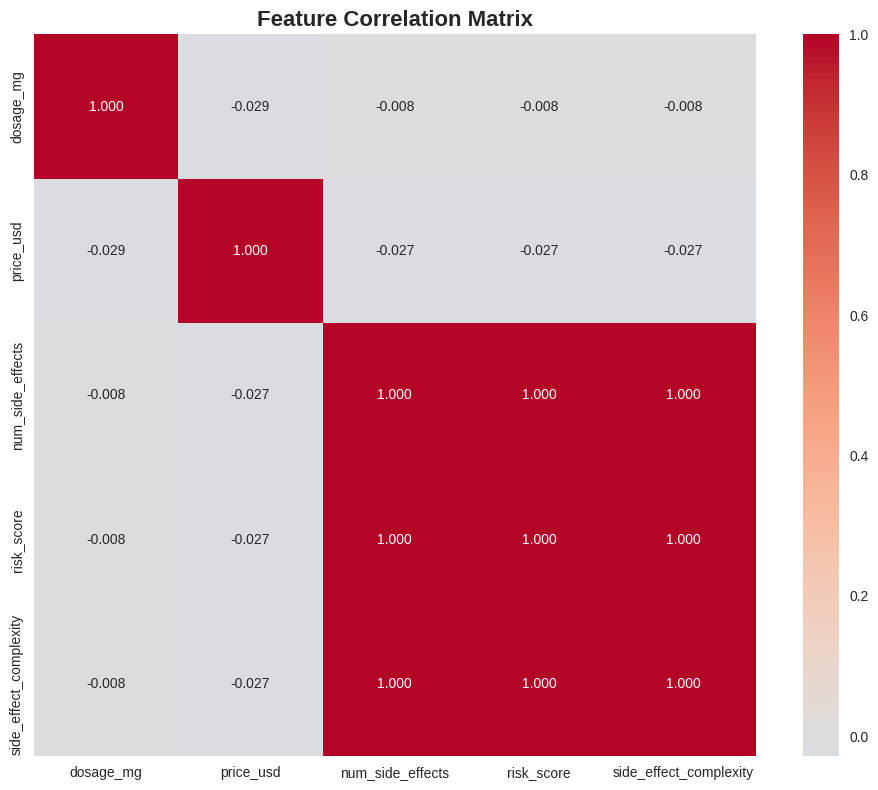


3. FEATURE SELECTION INSIGHTS:
   High Correlation Pairs:
   - num_side_effects vs risk_score: 1.000
   - num_side_effects vs side_effect_complexity: 1.000
   - risk_score vs side_effect_complexity: 1.000

4. DATA PREPROCESSING RECOMMENDATIONS:
   - Handle categorical variables with target encoding or one-hot encoding
   - Scale numerical features (StandardScaler or MinMaxScaler)
   - Use SMOTE for handling class imbalance in severity classification
   - Apply dimensionality reduction (PCA) if using all TF-IDF features
   - Consider feature selection (SelectKBest, RFE) to reduce overfitting

5. EVALUATION STRATEGY:
   - Stratified K-Fold cross-validation
   - Use macro-averaged F1 score for imbalanced classes
   - Confusion matrix analysis for classification errors
   - Feature importance analysis for interpretability
   - ROC curves for binary classification tasks


In [8]:
# Feature importance analysis and model recommendations
print("=== MACHINE LEARNING MODEL RECOMMENDATIONS ===")

# Create feature summary
feature_summary = {
    'Categorical Features': [
        'drug_class', 'manufacturer', 'administration_route', 'approval_status',
        'side_effect_severity', 'risk_category', 'dosage_category', 'price_category',
        'side_effect_category', 'mfg_class_combo'
    ],
    'Numerical Features': [
        'dosage_mg', 'price_usd', 'approval_year', 'years_since_approval',
        'num_side_effects', 'risk_score', 'side_effect_complexity'
    ],
    'Binary Features': [f'has_{effect.lower().replace(" ", "_")}' for effect in common_side_effects],
    'Text Features': list(tfidf_features)
}

print("\n1. FEATURE INVENTORY:")
total_features = 0
for feature_type, features in feature_summary.items():
    print(f"   {feature_type}: {len(features)} features")
    total_features += len(features)
print(f"   Total Features Available: {total_features}")

# Model-specific recommendations
print("\n2. MODEL-SPECIFIC RECOMMENDATIONS:")

print("\n   A. SIDE EFFECT SEVERITY CLASSIFICATION:")
print("      Target: side_effect_severity (Mild/Moderate/Severe)")
print("      Key Features:")
print("      - drug_class, dosage_mg, administration_route")
print("      - Binary side effect features")
print("      - side_effect_complexity, num_side_effects")
print("      - manufacturer (quality patterns)")
print("      Recommended Algorithms:")
print("      - Random Forest (handles mixed data types)")
print("      - XGBoost (excellent for tabular data)")
print("      - SVM with RBF kernel (for complex boundaries)")

print("\n   B. SIDE EFFECT CATEGORY PREDICTION:")
print("      Target: side_effect_category")
print("      Key Features:")
print("      - drug_class, dosage_mg, administration_route")
print("      - TF-IDF features from side effects text")
print("      - contraindications and warnings text")
print("      Recommended Algorithms:")
print("      - Naive Bayes (works well with text features)")
print("      - Logistic Regression (interpretable)")
print("      - Neural Networks (for complex text patterns)")

print("\n   C. RISK ASSESSMENT MODEL:")
print("      Target: risk_category (Low/Medium/High)")
print("      Key Features:")
print("      - All side effect features")
print("      - Contraindications and warnings count")
print("      - Drug class and manufacturer")
print("      - Dosage and administration route")
print("      Recommended Algorithms:")
print("      - Ensemble methods (Random Forest, Gradient Boosting)")
print("      - Deep Learning (for complex interactions)")

# Feature correlation analysis
numerical_features = ['dosage_mg', 'price_usd', 'num_side_effects', 'risk_score', 'side_effect_complexity']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n3. FEATURE SELECTION INSIGHTS:")
print("   High Correlation Pairs:")
for i in range(len(numerical_features)):
    for j in range(i+1, len(numerical_features)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            print(f"   - {numerical_features[i]} vs {numerical_features[j]}: {corr_val:.3f}")

print("\n4. DATA PREPROCESSING RECOMMENDATIONS:")
print("   - Handle categorical variables with target encoding or one-hot encoding")
print("   - Scale numerical features (StandardScaler or MinMaxScaler)")
print("   - Use SMOTE for handling class imbalance in severity classification")
print("   - Apply dimensionality reduction (PCA) if using all TF-IDF features")
print("   - Consider feature selection (SelectKBest, RFE) to reduce overfitting")

print("\n5. EVALUATION STRATEGY:")
print("   - Stratified K-Fold cross-validation")
print("   - Use macro-averaged F1 score for imbalanced classes")
print("   - Confusion matrix analysis for classification errors")
print("   - Feature importance analysis for interpretability")
print("   - ROC curves for binary classification tasks")

## 7. Final Feature Engineering Summary

In [10]:
# Create final engineered dataset summary
print("=== FINAL ENGINEERED DATASET SUMMARY ===")

# Count different types of features
original_features = ['drug_name', 'manufacturer', 'approval_year', 'drug_class', 'indications',
                    'side_effects', 'dosage_mg', 'administration_route', 'contraindications',
                    'warnings', 'price_usd', 'batch_number', 'expiry_date', 'side_effect_severity',
                    'approval_status']

engineered_features = [col for col in df.columns if col not in original_features]

print(f"Original Features: {len(original_features)}")
print(f"Engineered Features: {len(engineered_features)}")
print(f"Total Features: {len(df.columns)}")

print("\nEngineered Features by Category:")
print(f"  Side Effect Analysis: {len([f for f in engineered_features if 'side_effect' in f or 'has_' in f])}")
print(f"  Risk Assessment: {len([f for f in engineered_features if 'risk' in f])}")
print(f"  Categorical Binning: {len([f for f in engineered_features if 'category' in f])}")
print(f"  Temporal Features: {len([f for f in engineered_features if 'year' in f or 'decade' in f])}")
print(f"  Interaction Features: {len([f for f in engineered_features if 'combo' in f])}")

# Sample of the final dataset
print("\nSample of Key Engineered Features:")
key_features = ['drug_name', 'drug_class', 'side_effect_severity', 'num_side_effects', 
               'side_effect_complexity', 'risk_score', 'risk_category', 'side_effect_category']
print(df[key_features].head())

# Data quality check
print("\nData Quality Check:")
print(f"Missing values in engineered features: {df[engineered_features].isnull().sum().sum()}")
print(f"Dataset ready for ML modeling: {df[engineered_features].isnull().sum().sum() == 0}")

print("\n=== ANALYSIS COMPLETE ===")
print("The dataset is now ready for advanced machine learning applications!")
print("Key ML applications supported:")
print("✓ Drug Approval Prediction")
print("✓ Price Prediction")
print("✓ Side Effect Severity Classification")
print("✓ Risk Assessment Modeling")
print("✓ Market Success Analysis")

=== FINAL ENGINEERED DATASET SUMMARY ===
Original Features: 15
Engineered Features: 23
Total Features: 38

Engineered Features by Category:
  Side Effect Analysis: 14
  Risk Assessment: 2
  Categorical Binning: 4
  Temporal Features: 2
  Interaction Features: 1

Sample of Key Engineered Features:
      drug_name      drug_class side_effect_severity  num_side_effects  \
0  Seroxetine50  Antidepressant                 Mild                 2   
1   Mecoparin93         Vaccine                 Mild                 1   
2    Daxozole89   Antipsychotic             Moderate                 3   
3  Viracillin84      Antifungal                 Mild                 2   
4  Amoxstatin62  Antidepressant             Moderate                 3   

   side_effect_complexity  risk_score risk_category side_effect_category  
0                       2           4        Medium             Multiple  
1                       1           3           Low     Gastrointestinal  
2                       3       

In [12]:
df[engineered_features].to_csv('engineered_drug_labels.csv', index=False)